In [1]:
from vade.model import VADE, VAE
from vade.data import DATASETS
from torch.utils.data import DataLoader
from vade.device import DEVICE
from sklearn.cluster import KMeans
import torch
from torch import Tensor
import numpy as np
from sklearn.metrics import (
    rand_score,
    silhouette_score,
    calinski_harabasz_score,
)
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset_name = "HAR"

In [3]:
vae = (
    VAE.load_from_checkpoint(
        "results/2025-01-13__20-56-38/HAR/VAE/BasicTraining/lightning_logs/version_0/checkpoints/best_model-epoch=3-val_loss=0.0355-train_loss=0.0315.ckpt"
    )
    .to(DEVICE)
    .double()
)

vade = (
    VADE.load_from_checkpoint(
        "results/2025-01-13__20-56-38/HAR/VADE/BasicTraining/lightning_logs/version_0/checkpoints/best_model-epoch=45-val_loss=226.4211-train_loss=231.1780.ckpt"
    )
    .to(DEVICE)
    .double()
)

vade_pre = (
    VADE.load_from_checkpoint(
        "results/2025-01-13__20-56-38/HAR/VADE/TrainingWithPretrain/train/lightning_logs/version_0/checkpoints/best_model-epoch=61-val_loss=226.7165-train_loss=192.8468.ckpt"
    )
    .to(DEVICE)
    .double()
)

models = [vae, vade, vade_pre]
models_names = ["vae", "vade", "pretrained vade"]

In [4]:
dataset = DATASETS[dataset_name]["test"]
dataloader = DataLoader(dataset, 32)

### Prediction generation

In [5]:
predictions_m = []
latent_representations_m = []
true_labels_m = []

for model in models:
    predictions = []
    latent_representations = []
    true_labels = []
    for X, y in dataloader:
        X = X.to(DEVICE)
        with torch.no_grad():
            predictions.append(model(X))
            latent_representations.append(model.mu_encoder(model.encode(X)))
        true_labels.append(y)
    predictions = torch.concat(predictions).cpu().numpy()
    latent_representations = torch.concat(latent_representations).cpu().numpy()
    true_labels = torch.concat(true_labels).cpu().numpy()
    true_labels = np.ravel(true_labels)
    
    predictions_m.append(predictions)
    latent_representations_m.append(latent_representations)
    true_labels_m.append(true_labels)

n_clusters = np.unique(true_labels).shape[0]

### Clustering of latent space vs true classes & Clustering metrics of latent space

In [6]:
clusterings = []
for idx, model_name in enumerate(models_names):
    clustering = KMeans(n_clusters=n_clusters, random_state=123)
    clusters = clustering.fit_predict(latent_representations_m[idx])
    clusterings.append(clustering)
    print(f"{model_name}")
    print(f"rand socre: {rand_score(true_labels, clusters):.3f}")
    print(f"silhouette: {silhouette_score(latent_representations, clusters).item():.3f}")
    print(f"calinski-harabasz: {calinski_harabasz_score(latent_representations, clusters).item():.3f}\n")

vae
rand socre: 0.715
silhouette: -0.282
calinski-harabasz: 164.513

vade
rand socre: 0.830
silhouette: 0.454
calinski-harabasz: 7676.327

pretrained vade
rand socre: 0.828
silhouette: 0.498
calinski-harabasz: 11393.135



### Clusters visualizations
* (with true labels as colors)

In [7]:
stratified_sample_X_m = []
stratified_sample_true_labels_m = []
reduced_data_m = []

for idx, model_name in enumerate(models_names):
    stratified_sample_X = []
    stratified_sample_true_labels = []
    for i in range(n_clusters):
        stratified_sample_X.append(latent_representations_m[idx][true_labels == i][:100])
        stratified_sample_true_labels.append(true_labels_m[idx][true_labels == i][:100])
    stratified_sample_X = np.concat(stratified_sample_X)
    stratified_sample_true_labels = np.concat(stratified_sample_true_labels)

    stratified_sample_X = np.vstack([stratified_sample_X, model.mu.detach().cpu().numpy(), clusterings[idx].cluster_centers_])
    stratified_sample_true_labels = np.concat([stratified_sample_true_labels, np.ones(6)*-1, np.ones(6)*-2])
    
    stratified_sample_X_m.append(stratified_sample_X)
    stratified_sample_true_labels_m.append(stratified_sample_true_labels)
    
    reduced_data = TSNE(2).fit_transform(stratified_sample_X)
    reduced_data_m.append(reduced_data)

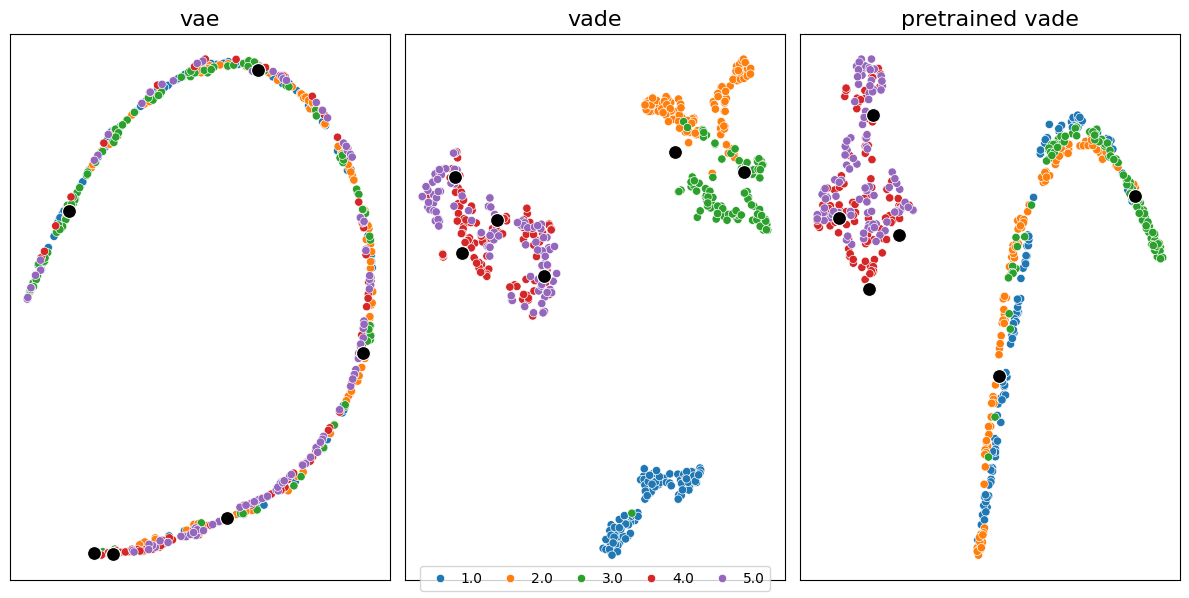

In [8]:

fig, ax = plt.subplots(figsize=(12, 6), ncols=3)
for idx, model_name in enumerate(models_names):
    sns.scatterplot(
        x=reduced_data_m[idx][:, 0][stratified_sample_true_labels_m[idx] > -1],
        y=reduced_data_m[idx][:, 1][stratified_sample_true_labels_m[idx] > -1],
        hue=stratified_sample_true_labels_m[idx][stratified_sample_true_labels_m[idx] > -1].tolist(),
        palette="tab10",
        ax=ax[idx],
        legend=True if idx == 0 else False
    )
    sns.scatterplot(
        x=reduced_data_m[idx][:, 0][stratified_sample_true_labels_m[idx] == -2],
        y=reduced_data_m[idx][:, 1][stratified_sample_true_labels_m[idx] == -2],
        color='black',
        s=100,
        ax=ax[idx],
        legend=False
    )
   
    ax[idx].set_title(model_name, fontsize=16)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    
ax[0].legend_.remove()
fig.legend(ncol=n_clusters, loc='lower center',
    columnspacing=1.0,
    handletextpad=0.5)
plt.tight_layout()

### Observation from each cluster 
* (for img visualize, for HAR calculate distance from points of this cluster, compare to distance from other cluster, compare to distances of real observations)

In [27]:
classes_m = []
for idx, model in enumerate(models[1:]):
    classes = []
    data = []
    for X, y in dataloader:
        X = X.to(DEVICE)
        data.append(X)
        classes.append(clusterings[idx+1].predict(model.mu_encoder(model.encode(X)).detach().cpu().numpy()))
    classes = np.concat(classes)
    X = torch.concat(data)
    classes_m.append(classes)

In [28]:
for idx, model in enumerate(models[1:]):
    within_distances = []
    between_distances = []
    for class_ in range(model.n_classes):
        r = torch.randn(size=(model.layers_sizes[-1],)).cuda()
        with torch.no_grad():
            z = (r * torch.exp(model.logvar[class_])) + Tensor(
                clusterings[idx+1].cluster_centers_[class_]
            ).cuda()
            mu, logvar = model.mu_encoder(z), model.logvar_encoder(z)
            latent = model.reparametrize(mu, logvar)
            output = model.decode(z)
        within_distances.append(
            torch.cdist(output.unsqueeze(0), X[classes_m[idx] == class_].double()).mean()
        )
        between_distances.append(
            torch.cdist(output.unsqueeze(0), X[classes_m[idx] != class_].double()).mean()
        )
    within_distances = torch.nanmean(torch.stack(within_distances))
    between_distances = torch.nanmean(torch.stack(between_distances))

    print(models_names[idx+1])
    print(f"within_distances: {within_distances:.3f}")
    print(f"between_distances: {between_distances:.3f}\n")

vade
within_distances: 2.909
between_distances: 5.653

pretrained vade
within_distances: 2.600
between_distances: 5.678

